**Imports**

In [7]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
#from datetime import datetime
#import seaborn as sns
import keras
import random
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2
import os
from dotenv import load_dotenv
import wandb
from wandb.keras import WandbCallback
load_dotenv()

True

**Unpack data** 

*NB: Size is 13.5 GB, code is commented out to prevent accidental unpacking*

**TEST THIS BEFORE HAND IN**

In [ ]:
#import tarfile
#file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

#file.extractall(os.getenv('TRAIN-PATH'))
#file.close()

**Metrics and loss**

In [8]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
        =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Loss functions here: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

ALPHA = 0.7
BETA = 0.3
GAMMA = 1

def focal_tversky_loss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + beta*FP + alpha*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_healthy(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,0] * y_pred[0,:,:,:,0]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,0])) + K.sum(K.square(y_pred[0,:,:,:,0])) + epsilon)

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

**Data constants**

In [9]:
IMG_SIZE=120 # Originally 240x240, we reduce this to reduce memory usage
SLICES=128 # Originally 155, reduced for same reason. Must be a power of 2 (or at least divisible by 2, 3 times)
SLICES_START=13 # We skip the first (and the last) few slices as they should contain less information
BATCH_SIZE=1
CHANNELS=4
DATA_AUG=False # Enables data augmentation
DATA_AUG_FACTOR=0 # If we have n data elements, we will have DATA_AUG_FACTOR*n data elements to train on

TRAIN_DATASET_PATH = os.getenv('TRAIN-PATH')

**Data generation**

In [10]:
def RandomBrightness(X, y):
  X = tf.image.stateless_random_brightness(X, 0.2, seed=(1,2)).numpy()
  y = tf.image.stateless_random_brightness(y, 0.2, seed=(1,2)).numpy()
  return X, y

def RandomRotate(X, y):
    r = random.randint(0,3)
    # rotate by 90 degrees times random r
    X = np.rot90(X, k=r)
    y = np.rot90(y, k=r)
    return X, y 
    
def AugmentData(X, y):
  X, y = RandomRotate(X, y)
  X, y = RandomBrightness(X, y)
  return X, y
  
data_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_ids = pathListIntoIds(data_directories); 

    
train_and_test_ids, val_ids = train_test_split(data_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.2)


keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = BATCH_SIZE, n_channels = CHANNELS, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*SLICES, IMG_SIZE, IMG_SIZE))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()   
            
            data_path = os.path.join(case_path, f'{i}_t1.nii.gz');
            t1 = nib.load(data_path).get_fdata()       

            data_path = os.path.join(case_path, f'{i}_t2.nii.gz');
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(SLICES):
                X[j+(SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,2] = cv2.resize(t1[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,3] = cv2.resize(t2[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))                
                
                y[j +SLICES*c,:,:] = cv2.resize(seg[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))

        if DATA_AUG: X, y = AugmentData(X, y)

        X = X.reshape(1,SLICES,IMG_SIZE,IMG_SIZE, CHANNELS)
        y = y.reshape(1,SLICES,IMG_SIZE,IMG_SIZE)
        # Generate masks
        #y[y==4] = 3;
        y = tf.one_hot(y, 4);

        # Avoid dividing by zero - return early
        if np.max(X) == 0.0:
          return np.zeros(X.shape), y

        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids*DATA_AUG_FACTOR) if DATA_AUG else DataGenerator(train_ids) 
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Baseline model**

In [11]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c2)
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = UpSampling3D(2)(c11)

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = UpSampling3D(2)(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = UpSampling3D(2)(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
model = unet_3d(input_layer) 

**Train and test (baseline) model**

In [12]:
LR = 0.01
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
model.summary()
model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[WandbCallback()])
if SAVE_MODEL:
  model.save("baseline_model.h5")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 120, 1  0           []                               
                                20, 4)]                                                           
                                                                                                  
 conv3d_15 (Conv3D)             (None, 128, 120, 12  872         ['input_2[0][0]']                
                                0, 8)                                                             
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 120, 12  32         ['conv3d_15[0][0]']              
 ormalization)                  0, 8)                                                       

KeyboardInterrupt: 

**Reconstruct model and test it**

In [13]:
reconstructed_model = keras.models.load_model("baseline_model.h5", custom_objects={"dice_coef":dice_coef, 
                                                                                "precision":precision, 
                                                                                "sensitivity":sensitivity, 
                                                                                "specificity":specificity,
                                                                                "dice_coef_necrotic":dice_coef_necrotic, 
                                                                                "dice_coef_edema":dice_coef_edema, 
                                                                                "dice_coef_enhancing":dice_coef_enhancing,
                                                                                "dice_coef_healthy": dice_coef_healthy})
reconstructed_model.evaluate(test_generator)

  5/200 [..............................] - ETA: 1:34 - loss: 0.0618 - accuracy: 0.9759 - mean_io_u_6: 0.3752 - dice_coef: 0.4240 - precision: 0.9807 - sensitivity: 0.9730 - specificity: 0.9937 - dice_coef_necrotic: 0.2309 - dice_coef_edema: 0.3966 - dice_coef_enhancing: 0.0773 - dice_coef_healthy: 0.9914

KeyboardInterrupt: 

**Evaluate on test data**

In [ ]:
model.evaluate(test_generator)

**Callbacks for improved model**

In [14]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
    ]

**Improved model definition**

In [15]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = Conv3D(16, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c2) # Use convolution instead of max pool
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = Conv3D(32, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = Conv3D(64, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = Conv3DTranspose(128, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c11) # Use Transpose instead of UpSampling, kernel size should be divisble by stride
    #c12 = UpSampling3D(2)(c11)

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = Conv3DTranspose(64, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c15)
    #c16 = UpSampling3D(2)(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = Conv3DTranspose(32, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c19)
    #c20 = UpSampling3D(2)(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
improved_model = unet_3d(input_layer) 
improved_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 120, 1  0           []                               
                                20, 4)]                                                           
                                                                                                  
 conv3d_30 (Conv3D)             (None, 128, 120, 12  872         ['input_3[0][0]']                
                                0, 8)                                                             
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 120, 12  32         ['conv3d_30[0][0]']              
 ormalization)                  0, 8)                                                       

**Train and test improved model**

In [16]:
LR = 0.001
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

improved_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=LR), loss=focal_tversky_loss, metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
improved_model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[callbacks, WandbCallback()])
if SAVE_MODEL:
  improved_model.save("improved_model.h5")


Epoch 1/20
 50/800 [>.............................] - ETA: 9:02 - loss: 0.6162 - accuracy: 0.8733 - mean_io_u_2: 0.3753 - dice_coef: 0.1926 - precision: 0.7697 - sensitivity: 0.2067 - specificity: 0.9845 - dice_coef_necrotic: 0.0506 - dice_coef_edema: 0.0708 - dice_coef_enhancing: 0.0018 - dice_coef_healthy: 0.6470

KeyboardInterrupt: 

**Evaluate improved model**

In [ ]:
improved_model.evaluate(test_generator)

**Plotting**

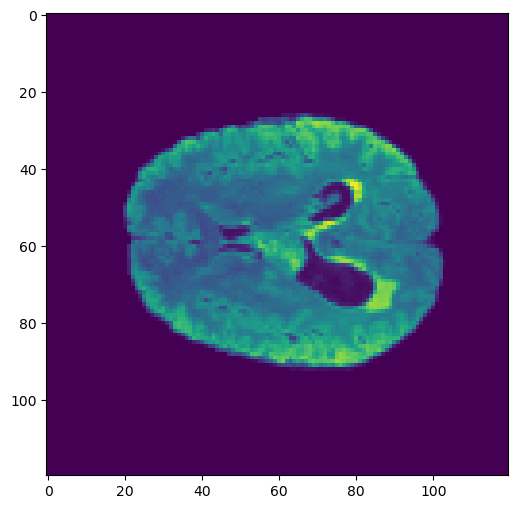

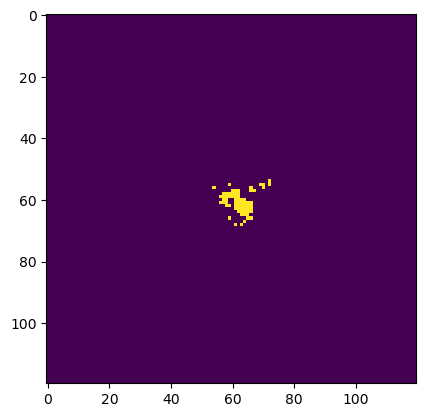

In [93]:
# First 0 is just an index of a 3D scan
# Next 0 is X in tuple X, y
# Next 0 is from the batch. We only have one, so we pick the first.
img1 = training_generator.__getitem__(0)[0][0]

# Get the ground truth of the training image above (i.e. y from tuple (X, y))
img2 = training_generator.__getitem__(0)[1][0]

plt.figure(figsize=(6,6))

# [70,:,:,0] is slice 70. 0 is the FLAIR channel.
plt.imshow(img1[70,:,:,0])
plt.show()

# Same slice as above, 1 is the necrotic tumor core
plt.imshow(img2[70, :, :, 1])
plt.show()

**Predictions? Maybe we should do an example (or a few) where we use the trained model to predict segmentation masks on data we have not trained on (i.e. the two brain scans that were included in the data set but not in the training-data file**

**Something like this:** https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ **(scroll down to "predictions")**